Sources:

Theory and Code : https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759

https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

https://stackoverflow.com/questions/66182884/how-to-implement-grad-cam-on-a-trained-network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from keras.models import load_model

In [ ]:
model = load_model('/content/drive/MyDrive/Academic_Courses_and_ML_Projects/Paper_Publications_Files/Paper_3/Ovarian_Image_classification_ResNet60.h5')
func_model = model

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
#image = cv2.imread('/content/drive/MyDrive/Academic_Courses_and_ML_Projects/Paper_Publications_Files/Paper_3/Model_Training_Dataset/Train/Benign/Folder_60_3_1_img252.jpg')
#image = cv2.imread('/content/drive/MyDrive/Academic_Courses_and_ML_Projects/Paper_Publications_Files/Paper_3/Annotated_Images/Annotated_Dataset/Benign/Folder_3_1_4_img064.jpeg')
#image = cv2.imread('/content/drive/MyDrive/Academic_Courses_and_ML_Projects/Paper_Publications_Files/Paper_3/Annotated_Images/Annotated_Dataset/Benign/Folder_3_1_5_img062.jpeg')
image = cv2.imread('/content/drive/MyDrive/Academic_Courses_and_ML_Projects/Paper_Publications_Files/Paper_3/Annotated_Images/Annotated_Dataset/Malignant/Folder_37_3_1_img6.jpg')

print('image shape: ', image.shape)
image = cv2.resize(image, (224, 224))
#image = cv2.resize(image, (32, 32))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = func_model.predict(image)
i = np.argmax(preds[0])

image shape:  (512, 512, 3)
1/1 [==============================] - 0s 27ms/step


In [ ]:
for idx in range(len(func_model.layers)):
  print(func_model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer

input_1
zero_padding2d
conv1
bn_conv1
activation
max_pooling2d
res2a_branch2a
bn2a_branch2a
activation_1
res2a_branch2b
bn2a_branch2b
activation_2
res2a_branch2c
res2a_branch1
bn2a_branch2c
bn2a_branch1
add
activation_3
res2b_branch2a
bn2b_branch2a
activation_4
res2b_branch2b
bn2b_branch2b
activation_5
res2b_branch2c
bn2b_branch2c
add_1
activation_6
res2c_branch2a
bn2c_branch2a
activation_7
res2c_branch2b
bn2c_branch2b
activation_8
res2c_branch2c
bn2c_branch2c
add_2
activation_9
res3a_branch2a
bn3a_branch2a
activation_10
res3a_branch2b
bn3a_branch2b
activation_11
res3a_branch2c
res3a_branch1
bn3a_branch2c
bn3a_branch1
add_3
activation_12
res3b_branch2a
bn3b_branch2a
activation_13
res3b_branch2b
bn3b_branch2b
activation_14
res3b_branch2c
bn3b_branch2c
add_4
activation_15
res3c_branch2a
bn3c_branch2a
activation_16
res3c_branch2b
bn3c_branch2b
activation_17
res3c_branch2c
bn3c_branch2c
add_5
activation_18
res3d_branch2a
bn3d_branch2a
activation_19
res3d_branch2b
bn3d_branch2b
activation_2

In [ ]:
#icam = GradCAM(func_model, i, 'res6c_branch2c')
icam = GradCAM(func_model, i, 'bn6c_branch2c')

img_1 = image
#img = tf.expand_dims(image, 0)
#img_1 = tf.repeat(img, repeats=1, axis=0)

heatmap = icam.compute_heatmap(img_1)
heatmap = cv2.resize(heatmap, (224, 224))

#image = cv2.imread('/content/drive/MyDrive/Academic_Courses_and_ML_Projects/Paper_Publications_Files/Paper_3/Model_Training_Dataset/Test/Benign/IM235_2.jpg')
#image = cv2.imread('/content/drive/MyDrive/Academic_Courses_and_ML_Projects/Paper_Publications_Files/Paper_3/Model_Training_Dataset/Train/Benign/Folder_60_3_1_img252.jpg')
#image = cv2.imread('/content/drive/MyDrive/Academic_Courses_and_ML_Projects/Paper_Publications_Files/Paper_3/Annotated_Images/Annotated_Dataset/Benign/Folder_3_1_4_img064.jpeg')
#image = cv2.imread('/content/drive/MyDrive/Academic_Courses_and_ML_Projects/Paper_Publications_Files/Paper_3/Annotated_Images/Annotated_Dataset/Benign/Folder_3_1_5_img062.jpeg')
image = cv2.imread('/content/drive/MyDrive/Academic_Courses_and_ML_Projects/Paper_Publications_Files/Paper_3/Annotated_Images/Annotated_Dataset/Malignant/Folder_37_3_1_img6.jpg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)


(224, 224) (224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

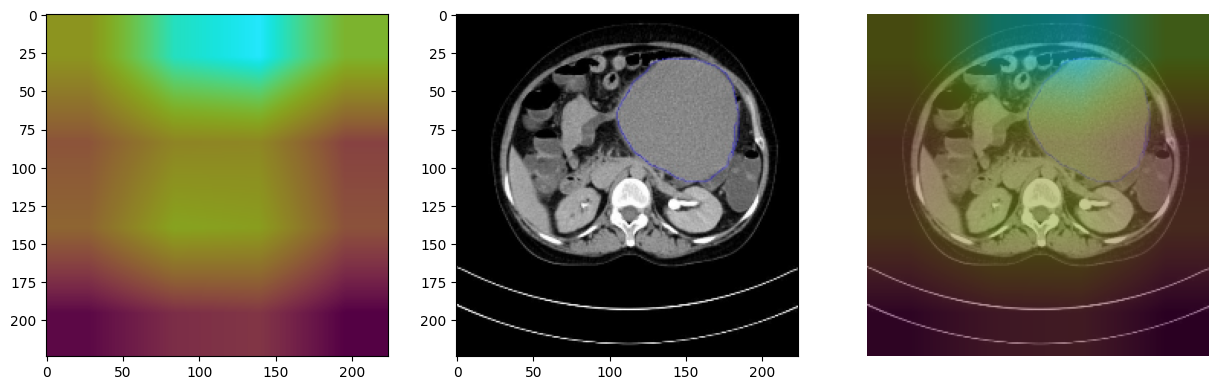

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(heatmap)
plt.axis('off')

ax[1].imshow(image)
plt.axis('off')

ax[2].imshow(output)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

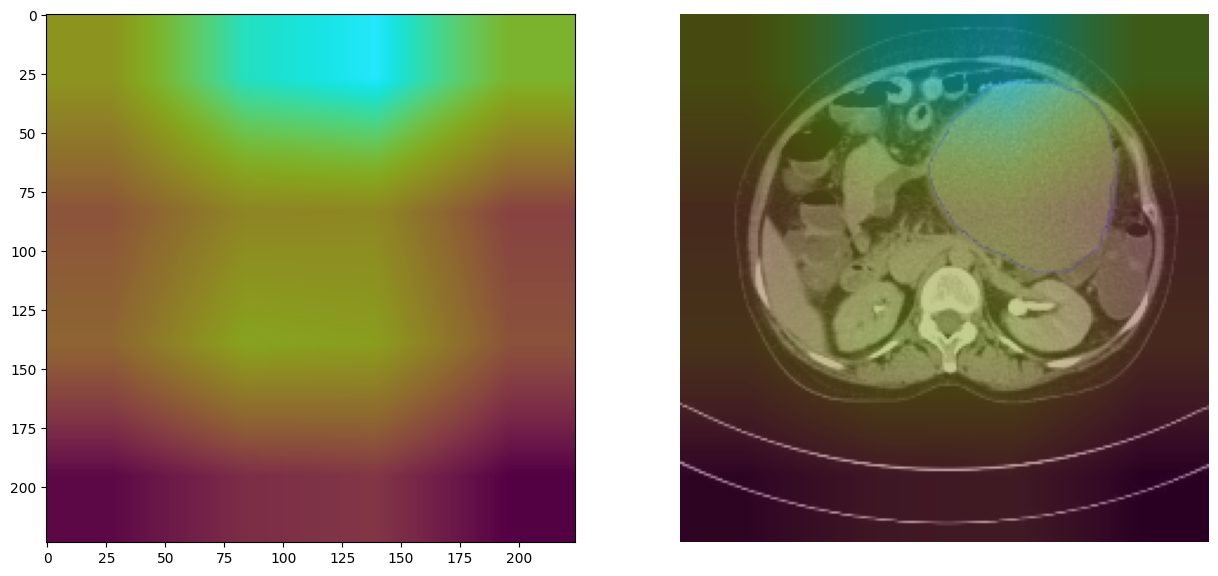

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(heatmap)
plt.axis('off')

#ax[1].imshow(image)
#plt.axis('off')

ax[1].imshow(output)
plt.axis('off')